In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arxiv-data/arxiv_data.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score
import gc

In [3]:
data = pd.read_csv('/kaggle/input/arxiv-data/arxiv_data.csv')[:70000]
data

,abstract,tag,title
0,we propose an architecture for vqa which utili...,cs.AI,dual recurrent attention units for visual ques...
1,recent approaches based on artificial neural n...,cs.CL,sequential short text classification with recu...
2,we introduce the multiresolution recurrent neu...,cs.CL,multiresolution recurrent neural networks an ...
3,multi task learning is motivated by the observ...,stat.ML,learning what to share between loosely related...
4,we present milabot a deep reinforcement learn...,cs.CL,a deep reinforcement learning chatbot
...,...,...,...
69995,we consider a colocated mimo radar scenario ...,cs.IT,target estimation in colocated mimo radar via ...
69996,let k be a field and x subset p 3_ k a...,math.AG,normes de droites sur les surfaces cubiques
69997,we investigate the field emission properties...,cond-mat.mtrl-sci,first principles calculation of field emission...
69998,recent nuclear magnetic resonance and elasti...,cond-mat.str-el,nmr studies of field induced magnetism in ceco...


In [4]:
tagg = data.groupby(['tag']).count().sort_values(by='abstract')

In [5]:
tags_count = {tagg.index[ind] : tagg.iloc[ind]['abstract'] for ind in range(tagg.shape[0])}
tags_count

{'econ.TH': 1,
 'cs.GL': 3,
 'cs.OS': 7,
 'q-fin.EC': 7,
 'econ.GN': 8,
 'eess.SY': 9,
 'q-bio.OT': 11,
 'nlin.CG': 12,
 'q-bio.SC': 12,
 'cs.PF': 13,
 'stat.OT': 15,
 'q-fin.CP': 15,
 'q-bio.CB': 16,
 'econ.EM': 17,
 'q-fin.MF': 18,
 'q-fin.RM': 18,
 'physics.pop-ph': 18,
 'q-bio.TO': 19,
 'q-fin.GN': 21,
 'physics.atm-clus': 22,
 'q-fin.PM': 22,
 'q-fin.TR': 25,
 'q-fin.PR': 26,
 'cs.SC': 27,
 'eess.AS': 28,
 'cs.AR': 29,
 'math.KT': 33,
 'q-fin.ST': 33,
 'physics.geo-ph': 34,
 'physics.space-ph': 34,
 'cs.MS': 35,
 'q-bio.MN': 38,
 'physics.ao-ph': 39,
 'math.GN': 40,
 'math.HO': 42,
 'physics.ed-ph': 44,
 'math.GM': 45,
 'cs.OH': 45,
 'physics.hist-ph': 46,
 'q-bio.GN': 46,
 'q-bio.BM': 48,
 'cs.FL': 54,
 'physics.class-ph': 56,
 'math.CT': 58,
 'math.SG': 60,
 'eess.IV': 62,
 'nlin.AO': 64,
 'nlin.PS': 69,
 'cs.ET': 72,
 'cs.GR': 72,
 'physics.acc-ph': 76,
 'math.SP': 77,
 'physics.med-ph': 78,
 'cs.DM': 79,
 'cs.CG': 79,
 'cs.DL': 82,
 'nlin.SI': 82,
 'physics.app-ph': 84,
 'cs.N

In [6]:
bad_tags = []
for tag in tags_count:
    if tags_count[tag] < 100:
        bad_tags.append(tag)       

In [7]:
data['tag'] = data['tag'].apply(lambda x : x if x not in bad_tags else None)

In [8]:
data = data.dropna(axis=0)

In [9]:
tags_true_names = data['tag']
tags_true_names

0                    cs.AI
1                    cs.CL
2                    cs.CL
3                  stat.ML
4                    cs.CL
               ...        
69994              math.OC
69995                cs.IT
69996              math.AG
69997    cond-mat.mtrl-sci
69998      cond-mat.str-el
Name: tag, Length: 67309, dtype: object

In [10]:
tags_true_names.values

array(['cs.AI', 'cs.CL', 'cs.CL', ..., 'math.AG', 'cond-mat.mtrl-sci',
       'cond-mat.str-el'], dtype=object)

In [11]:
le = LabelEncoder()
data['tag'] = le.fit_transform(data['tag'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
convert = {data.iloc[ind]['tag'] : tags_true_names.values[ind] for ind in range(data.shape[0])}

In [13]:
convert

{15: 'cs.AI',
 18: 'cs.CL',
 88: 'stat.ML',
 20: 'cs.CV',
 29: 'cs.LG',
 33: 'cs.NE',
 35: 'cs.RO',
 27: 'cs.IR',
 28: 'cs.IT',
 4: 'astro-ph.IM',
 22: 'cs.DB',
 37: 'cs.SE',
 81: 'q-bio.NC',
 38: 'cs.SI',
 19: 'cs.CR',
 36: 'cs.SD',
 34: 'cs.NI',
 6: 'cond-mat.dis-nn',
 62: 'math.OC',
 59: 'math.NA',
 16: 'cs.CC',
 32: 'cs.MM',
 23: 'cs.DC',
 26: 'cs.HC',
 21: 'cs.CY',
 83: 'q-bio.QM',
 84: 'quant-ph',
 39: 'cs.SY',
 85: 'stat.AP',
 25: 'cs.GT',
 78: 'physics.optics',
 40: 'gr-qc',
 86: 'stat.CO',
 73: 'physics.comp-ph',
 67: 'math.ST',
 24: 'cs.DS',
 31: 'cs.MA',
 17: 'cs.CE',
 0: 'astro-ph.CO',
 74: 'physics.data-an',
 87: 'stat.ME',
 63: 'math.PR',
 80: 'physics.soc-ph',
 12: 'cond-mat.stat-mech',
 54: 'math.DS',
 55: 'math.FA',
 48: 'math.AP',
 2: 'astro-ph.GA',
 30: 'cs.LO',
 82: 'q-bio.PE',
 51: 'math.CO',
 57: 'math.GT',
 8: 'cond-mat.mtrl-sci',
 72: 'physics.chem-ph',
 53: 'math.DG',
 41: 'hep-ex',
 1: 'astro-ph.EP',
 44: 'hep-th',
 49: 'math.AT',
 70: 'nucl-th',
 43: 'hep-ph'

In [14]:
data['abstract'] = data['abstract'].apply(lambda x : " ".join(x.split()))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
data['title'] = data['title'].apply(lambda x : " ".join(x.split()))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
new_data = pd.DataFrame(columns=data.columns)
for tag in data['tag'].unique():
    part = data[data['tag']==tag]
    new_data = pd.concat([new_data, part[:min(part.shape[0], 1500)]], axis=0)
new_data    

,abstract,tag,title
0,we propose an architecture for vqa which utili...,15,dual recurrent attention units for visual ques...
12,recent progress in artificial intelligence ai ...,15,building machines that learn and think like pe...
65,we propose neural reasoner a framework for neu...,15,towards neural network based reasoning
69,we proposed neural enquirer as a neural networ...,15,neural enquirer learning to query tables with ...
76,we introduce ll rnns log linear rnns an extens...,15,log linear rnns towards recurrent neural netwo...
...,...,...,...
68466,the purpose of this paper is to give affirmati...,46,asymptotic behaviour of parameter ideals in ge...
68714,let i subset s kk x_1 x_n be an ideal generate...,46,when will the stanley depth increase
69609,in this paper we continue the study of which h...,46,artinian level algebras of codimension 3
69871,the aim of this paper is to prove characteriza...,46,characterization of field homomorphisms throug...


In [51]:
X_train, X_test, y_train, y_test = train_test_split(new_data.drop(columns='tag'), new_data['tag'], test_size = 0.2, random_state=777, stratify=new_data['tag'], shuffle=True)

In [53]:
y_train.shape

(31024,)

In [54]:
print(len(y_train.unique()), len(y_test.unique()))

89 89


In [55]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

In [56]:
titles_train = np.array(X_train['title'].values)
abstracts_train = np.array(X_train['abstract'].values)

titles_test = np.array(X_test['title'].values)
abstracts_test = np.array(X_test['abstract'].values)

In [57]:
train = []
test = []
for index in range(len(titles_train)):
    train.append(titles_train[index] + ' # ' + abstracts_train[index])
for index in range(len(titles_test)):
    test.append(titles_test[index] + ' # ' + abstracts_test[index])

In [58]:
del data
gc.collect()

18996

In [59]:
tokenized_train = tokenizer(train, padding='max_length', truncation=True, return_tensors="pt", return_token_type_ids=True)
#tokenized_test = tokenizer(test, padding='max_length', truncation=True, return_tensors="pt", return_token_type_ids=True)

In [60]:
tokenized_test = tokenizer(test, padding='max_length', max_length=512, truncation=True, return_tensors="pt", return_token_type_ids=True)

In [83]:
class CustomDataset(Dataset):
    def __init__(self, tokenized, targets):
        self.tokenized = tokenized
        self.targets = targets
        
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        ids = self.tokenized['input_ids'][idx]
        label = self.targets[idx]
        mask = self.tokenized['attention_mask'][idx]
    #    token_type_ids = self.tokenized['token_type_ids'][idx]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
        #    'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(label, dtype=torch.long)
        }

In [84]:
train_data = CustomDataset(tokenized_train, y_train.values)
test_data = CustomDataset(tokenized_test, y_test.values)

In [85]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [87]:
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 12
LEARNING_RATE = 1e-2

In [88]:
training_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
testing_loader = DataLoader(test_data, batch_size=VALID_BATCH_SIZE)

In [89]:
class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.bert = AutoModel.from_pretrained('distilbert-base-cased')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.pre_classifier = torch.nn.Linear(768, 1024)
        self.classifier = torch.nn.Linear(1024, 152)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, input_ids, attention_mask):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        output = self.classifier(pooler)
        return self.softmax(output)

In [91]:
model = BertClass()
model.to(device)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClass(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_features=

In [94]:
loss_function = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [95]:
def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for data in tqdm(loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
    #    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        
        optimizer.zero_grad()
        out = model(ids, mask)
        loss = criterion(out, targets)
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

In [96]:
def val(model, loader, criterion):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for data in tqdm(loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
        #    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
        
            out = model(ids, mask)
            loss = criterion(out, targets)

            losses_val.append(loss.item())
    
    return np.mean(losses_val)

In [113]:
def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct / len(preds)

In [98]:
from IPython.display import clear_output
from tqdm.notebook import trange


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def learning_loop(model, optimizer, train_loader, val_loader, criterion, scheduler=None, min_lr=None, epochs=1, val_every=1, draw_every=1, separate_show=False):
    losses = {'train': [], 'val': []}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss = val(model, val_loader, criterion)
            losses['val'].append(loss)
            if scheduler:
                scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2 if separate_show else 1, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            if separate_show:
                plt.subplot(121)
                plt.title('loss on train')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.legend()

            if separate_show:
                plt.subplot(122)
                plt.title('loss on validation')
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

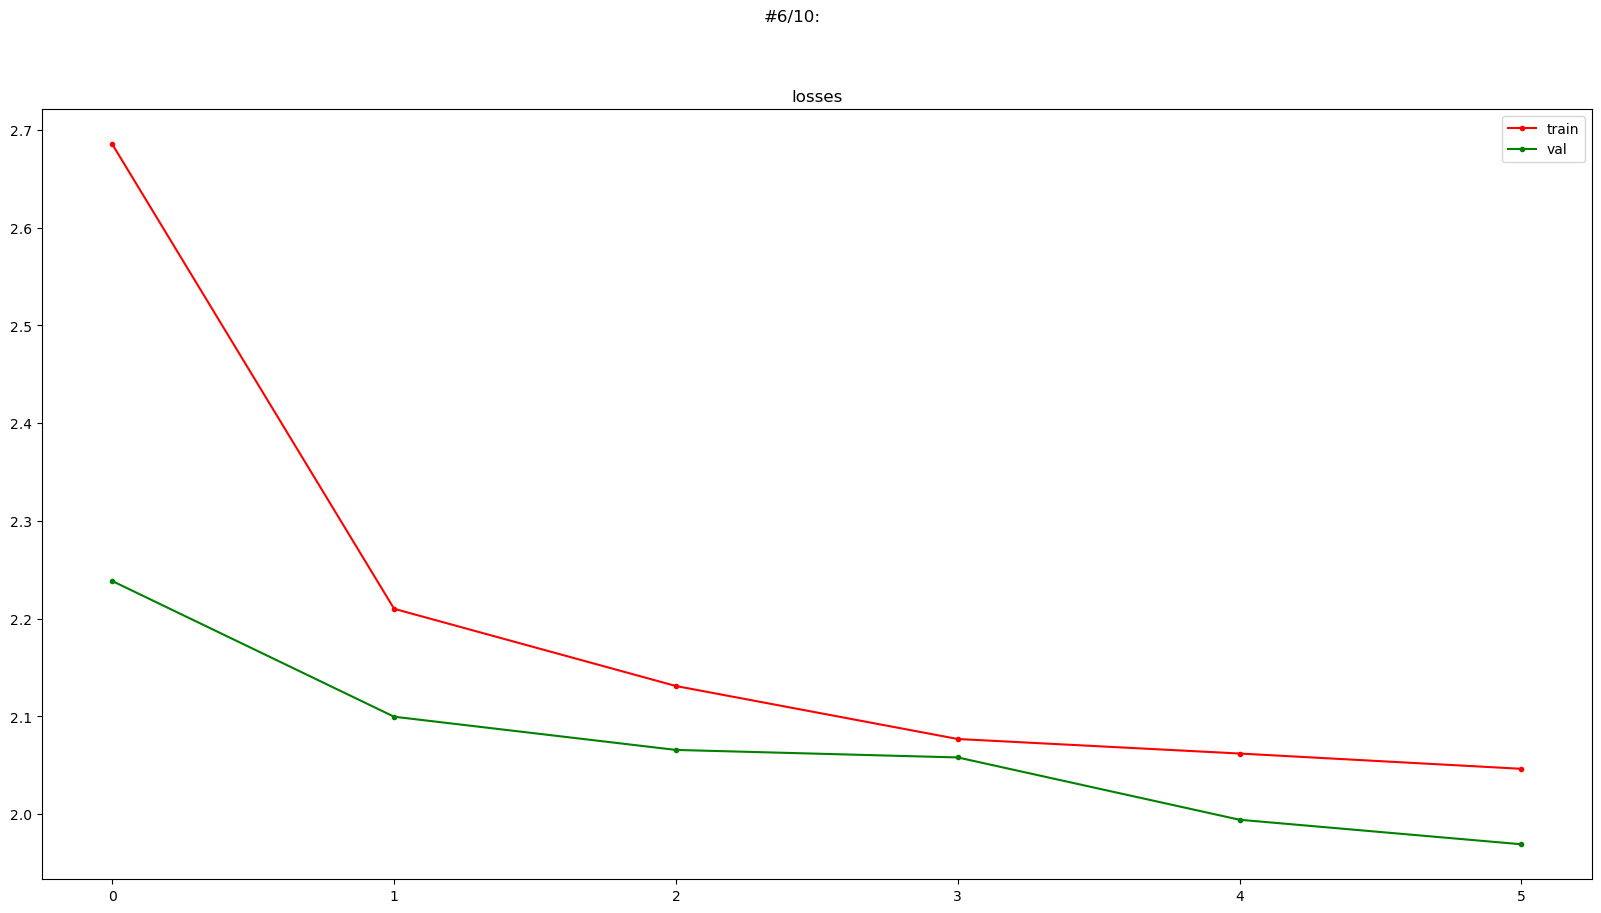

#7/10:


  0%|          | 0/485 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [99]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    train_loader = training_loader,
    val_loader = testing_loader,
    criterion = loss_function,
    epochs = 10,
    min_lr = 2e-6
)

In [100]:
model.eval()
acc_val = 0.0
preds = []
outt = None
with torch.no_grad():
    for data in tqdm(testing_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
    #    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        if (len(preds) == 0):
            print(ids)
            print(mask)
        out = model(ids, mask)
        if (len(preds) == 0):
            outt = torch.exp(out)
        tags = torch.argmax(torch.exp(out), axis=1)
        preds.extend(tags)
preds = [pred.item() for pred in preds]

  0%|          | 0/647 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


tensor([[ 101, 4574, 5236,  ...,    0,    0,    0],
        [ 101, 2179, 4484,  ...,    0,    0,    0],
        [ 101, 1113,  177,  ...,    0,    0,    0],
        ...,
        [ 101, 8910, 2495,  ...,    0,    0,    0],
        [ 101, 1121, 5420,  ...,    0,    0,    0],
        [ 101, 1113, 1103,  ...,    0,    0,    0]], device='cuda:0')
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')


In [ ]:
#torch.save(model.state_dict(), 'model.pt')

In [114]:
calculate_accuracy(y_test, preds)

0.38898916967509023